# Assignment

In [1]:
import os
import csv
import matplotlib.pyplot as plt
import pandas as pd

from pandas_schema import Column, Schema
from pandas_schema.validation import CanConvertValidation, DateFormatValidation, MatchesPatternValidation
from GeoBases import GeoBase

## Explore data

### Question 1 results

`kz@kz-virtualbox:/media/sf_SharedVirtbox/bookings.csv$ wc -l bookings.csv 
10000011 bookings.csv 
kz@kz-virtualbox:/media/sf_SharedVirtbox/searches.csv$ wc -l searches.csv 
20390198 searches.csv`

In [4]:
filename = '/media/sf_SharedVirtbox/bookings.csv/bookings.csv'
columns = ['arr_port', 'pax']

bookings_df = pd.read_csv(filename, nrows=10, sep='^', usecols=columns)
bookings_df.head()

,arr_port,pax
0,LHR,-1
1,CLT,1
2,CLT,1
3,SVO,1
4,SVO,1


## Validate some CSV entries & process dataframes

In [2]:
# Note: Sum of pax returned float -> invalid entry in dataset -> verification needed
# Choosing to remove the invalid entries
# Very basic validation

schema = Schema([
    Column('arr_port', [CanConvertValidation(str)]),
    Column('pax', [CanConvertValidation(int)])
])

def removeInvalidEntries(chunk, errors):
    for error in errors:
        # Remove a row once, if multiple errors
        if error.row in chunk.index:
            #print(error.__str__() + "\nRemoving this row\n")
            chunk = chunk.drop([error.row], axis=0)
    return chunk

In [5]:
# Read huge dataset (GBs size .csv) by chunks to avoid OOM, chunksize at will for now 
# Perform groupby on chunked dataframes, then a final one combining these
chunksize = 100000

dataframes = []
df = None

for chunk in pd.read_csv(filename, sep='^', usecols=columns, chunksize=chunksize):
    errors_in_chunk = schema.validate(chunk)
    if errors_in_chunk:
        chunk = removeInvalidEntries(chunk, errors_in_chunk)
    dataframes.append(chunk.groupby(['arr_port'], as_index=False).sum())

df = pd.concat(dataframes)
nb_pax_per_airport = df.groupby(['arr_port'], as_index=False).sum()

## Show list of 10 biggest airports per pax arrivals

In [63]:
nb_pax_per_airport_10 = nb_pax_per_airport.sort_values('pax', ascending=False).head(10)

In [64]:
nb_pax_per_airport_10

,arr_port,pax
1088,LHR,88809.0
1190,MCO,70930.0
1050,LAX,70530.0
1047,LAS,69630.0
886,JFK,66270.0
315,CDG,64490.0
216,BKK,59460.0
1228,MIA,58150.0
1719,SFO,58000.0
517,DXB,55590.0


## Question 2 results - Show the same list with readable names

In [65]:
# Load database of airports from Geobase
geo_a = GeoBase(data='airports', verbose=False)

def getAirportName(iata_code):
    return geo_a.get(iata_code.strip(), 'name')

In [66]:
nb_pax_per_airport_10['arr_port'] = nb_pax_per_airport_10['arr_port'].apply(getAirportName)

In [67]:
nb_pax_per_airport_10

,arr_port,pax
1088,London Heathrow Airport,88809.0
1190,Orlando International Airport,70930.0
1050,Los Angeles International Airport,70530.0
1047,McCarran International Airport,69630.0
886,John F Kennedy International Airport,66270.0
315,Paris - Charles-de-Gaulle,64490.0
216,Suvarnabhumi,59460.0
1228,Miami International Airport,58150.0
1719,San Francisco International Airport,58000.0
517,Dubai International Airport,55590.0


## Plot monthly # of arrivals at MAD, BCN or AGP

In [68]:
filename = '/media/sf_SharedVirtbox/searches.csv/searches.csv'
columns = ['Date', 'Destination']

search_df = pd.read_csv(filename, nrows=20, sep='^', usecols=columns)

In [82]:
chunksize = 1000000

dataframes = []
df = None

# Validation on dates format (year-month-day)
schema = Schema([
    Column('Date', [DateFormatValidation("%Y-%m-%d")]),
    Column('Destination', [CanConvertValidation(str)])
])

for chunk in pd.read_csv(filename, sep='^', usecols=columns, chunksize=chunksize):
    errors_in_chunk = schema.validate(chunk)
    if errors_in_chunk:
        chunk = removeInvalidEntries(chunk, errors_in_chunk)
        
    mad = chunk['Destination'] == "MAD"
    bcn = chunk['Destination'] == "BCN"
    agp = chunk['Destination'] == "AGP"
    # Keep only what interests us
    chunk = chunk[mad|bcn|agp]
    
    # Convert str to datetime datastruct for easy manipulation
    chunk['Date'] = pd.to_datetime(chunk['Date'])
    dataframes.append(chunk.groupby([pd.Grouper(key='Date', freq='M'), "Destination"]).Date.count().reset_index(name='count'))

df = pd.concat(dataframes)

In [74]:
# Reset index to recover DF from DFGroupby
numberof_arrivals_airports = df.groupby(["Date", "Destination"]).sum().reset_index()
numberof_arrivals_airports.head(10)

,Date,Destination,count
0,2013-01-31,AGP,9633
1,2013-01-31,BCN,29469
2,2013-01-31,MAD,24258
3,2013-02-28,AGP,8379
4,2013-02-28,BCN,28329
5,2013-02-28,MAD,22800
6,2013-03-31,AGP,10659
7,2013-03-31,BCN,30552
8,2013-03-31,MAD,24681
9,2013-04-30,AGP,8265


## Question 3 results - Creating the graph for the three airports (IATA codes)

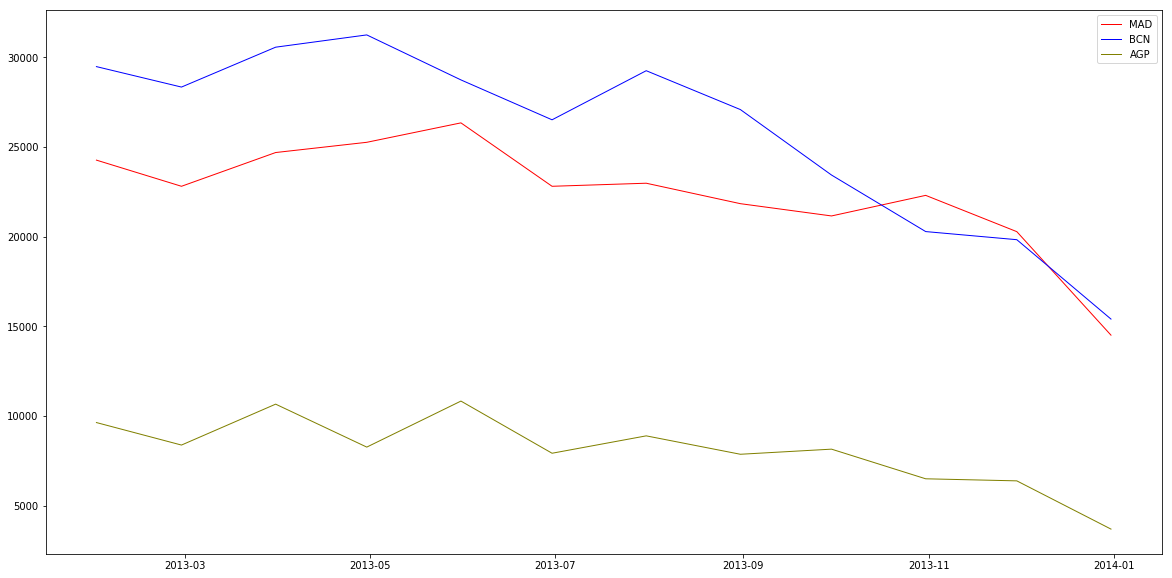

In [78]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot_date(numberof_arrivals_airports[numberof_arrivals_airports['Destination'] == 'MAD']['Date'], numberof_arrivals_airports[numberof_arrivals_airports['Destination'] == 'MAD']['count'], 'b-', color='red', linewidth=1,label="MAD")
plt.plot_date(numberof_arrivals_airports[numberof_arrivals_airports['Destination'] == 'BCN']['Date'], numberof_arrivals_airports[numberof_arrivals_airports['Destination'] == 'BCN']['count'], 'b-', color='blue', linewidth=1,label="BCN")
plt.plot_date(numberof_arrivals_airports[numberof_arrivals_airports['Destination'] == 'AGP']['Date'], numberof_arrivals_airports[numberof_arrivals_airports['Destination'] == 'AGP']['count'], 'b-', color='olive', linewidth=1, label="AGP")
plt.legend()


## Searches that ended up in bookings

### Sanitize and merge sort the contents of searches.csv and bookings.csv

In [80]:
chunksize = 40000

filename_searches = '/media/sf_SharedVirtbox/searches.csv/searches.csv'
filename_bookings = '/media/sf_SharedVirtbox/bookings.csv/bookings.csv'
filename_filtered_searches = '/media/sf_SharedVirtbox/searches.csv/searches_filtered.csv'
filename_filtered_bookings = '/media/sf_SharedVirtbox/bookings.csv/bookings_filtered.csv'

schema_searches  = Schema([
    Column('Date', [DateFormatValidation("%Y-%m-%d")]),
    Column('Time', [DateFormatValidation("%H:%M:%S")]),
    Column('TxnCode', [CanConvertValidation(str)]),
    Column('OfficeID', [CanConvertValidation(str)]),
    Column('Country', [CanConvertValidation(str)]),
    Column('Origin', [MatchesPatternValidation("[A-Z]{3}")]),
    Column('Destination', [MatchesPatternValidation("[A-Z]{3}")]),
    Column('RoundTrip', [CanConvertValidation(int)]),
    Column('NbSegments', [CanConvertValidation(int)]),
    Column('Seg1Departure', [CanConvertValidation(str)]),
    Column('Seg1Arrival', [CanConvertValidation(str)]),
    Column('Seg1Date', [CanConvertValidation(str)]),
    Column('Seg1Carrier', [CanConvertValidation(str)]),
    Column('Seg1BookingCode', [CanConvertValidation(str)]),
    Column('Seg2Departure', [CanConvertValidation(str)]),
    Column('Seg2Arrival', [CanConvertValidation(str)]),
    Column('Seg2Date', [CanConvertValidation(str)]),
    Column('Seg2Carrier', [CanConvertValidation(str)]),
    Column('Seg2BookingCode', [CanConvertValidation(str)]),
    Column('Seg3Departure', [CanConvertValidation(str)]),
    Column('Seg3Arrival', [CanConvertValidation(str)]),
    Column('Seg3Date', [CanConvertValidation(str)]),
    Column('Seg3Carrier', [CanConvertValidation(str)]),
    Column('Seg3BookingCode', [CanConvertValidation(str)]),
    Column('Seg4Departure', [CanConvertValidation(str)]),
    Column('Seg4Arrival', [CanConvertValidation(str)]),
    Column('Seg4Date', [CanConvertValidation(str)]),
    Column('Seg4Carrier', [CanConvertValidation(str)]),
    Column('Seg4BookingCode', [CanConvertValidation(str)]),
    Column('Seg5Departure', [CanConvertValidation(str)]),
    Column('Seg5Arrival', [CanConvertValidation(str)]),
    Column('Seg5Date', [CanConvertValidation(str)]),
    Column('Seg5Carrier', [CanConvertValidation(str)]),
    Column('Seg5BookingCode', [CanConvertValidation(str)]),
    Column('Seg6Departure', [CanConvertValidation(str)]),
    Column('Seg6Arrival', [CanConvertValidation(str)]),
    Column('Seg6Date', [CanConvertValidation(str)]),
    Column('Seg6Carrier', [CanConvertValidation(str)]),
    Column('Seg6BookingCode', [CanConvertValidation(str)]),
    Column('From', [CanConvertValidation(str)]),
    Column('IsPublishedForNeg', [CanConvertValidation(str)]),
    Column('IsFromInternet', [CanConvertValidation(str)]),
    Column('IsFromVista', [CanConvertValidation(str)]),
    Column('TerminalID', [CanConvertValidation(str)]),
    Column('InternetOffice', [CanConvertValidation(str)])
])

schema_bookings  = Schema([
    Column('act_date', [DateFormatValidation("%Y-%m-%d %H:%M:%S")]),    
    Column('source', [CanConvertValidation(str)]),
    Column('pos_ctry', [CanConvertValidation(str)]),
    Column('pos_iata', [CanConvertValidation(str)]),
    Column('pos_oid', [CanConvertValidation(str)]),
    Column('rloc', [CanConvertValidation(str)]),
    Column('cre_date', [DateFormatValidation("%Y-%m-%d %H:%M:%S")]),  
    Column('duration', [CanConvertValidation(int)]),
    Column('distance', [CanConvertValidation(int)]),
    Column('dep_port', [MatchesPatternValidation("[A-Z]{3}")]),
    Column('dep_city', [CanConvertValidation(str)]),
    Column('dep_ctry', [CanConvertValidation(str)]),
    Column('arr_port', [MatchesPatternValidation("[A-Z]{3}")]),
    Column('arr_city', [CanConvertValidation(str)]),
    Column('arr_ctry', [CanConvertValidation(str)]),
    Column('lst_port', [CanConvertValidation(str)]),
    Column('lst_city', [CanConvertValidation(str)]),
    Column('lst_ctry', [CanConvertValidation(str)]),
    Column('brd_port', [CanConvertValidation(str)]),
    Column('brd_city', [CanConvertValidation(str)]),
    Column('brd_ctry', [CanConvertValidation(str)]),
    Column('off_port', [CanConvertValidation(str)]),
    Column('off_city', [CanConvertValidation(str)]),
    Column('off_ctry', [CanConvertValidation(str)]),
    Column('mkt_port', [CanConvertValidation(str)]),
    Column('mkt_city', [CanConvertValidation(str)]),
    Column('mkt_ctry', [CanConvertValidation(str)]),
    Column('intl', [CanConvertValidation(int)]),
    Column('route', [CanConvertValidation(str)]),
    Column('carrier', [CanConvertValidation(str)]),
    Column('bkg_class', [CanConvertValidation(str)]),
    Column('cab_class', [CanConvertValidation(str)]),
    Column('brd_time', [DateFormatValidation("%Y-%m-%d %H:%M:%S")]),
    Column('off_time', [DateFormatValidation("%Y-%m-%d %H:%M:%S")]), 
    Column('pax', [CanConvertValidation(int)]),
    Column('year', [DateFormatValidation("%Y")]),
    Column('month', [DateFormatValidation("%m")]),
    Column('oid', [CanConvertValidation(str)]),
])

# Remove spaces in .csv entries
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text


# Write the headers
if not os.path.isfile(filename_filtered_searches):
    with open(filename_searches, newline='') as searches, open(filename_filtered_searches, newline='', mode='w') as output:
        header = searches.readline()
        output.write(header)
        
if not os.path.isfile(filename_filtered_bookings):
    with open(filename_bookings, newline='') as bookings, open(filename_filtered_bookings, newline='', mode='w') as output:
        header = bookings.readline()
        output.write(header)

# Validate entries and write to CSV    
for chunk in pd.read_csv(filename_searches, sep='^', chunksize=chunksize, 
                         converters = {'Origin' : strip,
                                       'Destination' : strip}):
    errors_in_chunk = schema_searches.validate(chunk)
    if errors_in_chunk:
        chunk = removeInvalidEntries(chunk, errors_in_chunk)
    chunk.to_csv(path_or_buf=filename_filtered_searches, mode='a', sep='^', index=False, header=False)
        
for chunk in pd.read_csv(filename_bookings, sep='^', chunksize=chunksize, 
                         converters = {'dep_port' : strip,
                                       'arr_port' : strip}):
    errors_in_chunk = schema_bookings.validate(chunk)
    if errors_in_chunk:
        chunk = removeInvalidEntries(chunk, errors_in_chunk)
    chunk.to_csv(path_or_buf=filename_filtered_bookings, mode='a', sep='^', index=False, header=False)

### External merge sort with sort utility

In [29]:
#head -n1 searches_filtered.csv > searches_sorted.csv && sort --field-separator='^' --key=6,7 <(tail -n+2 searches_filtered.csv) >> searches_sorted.csv
#head -n1 bookings_filtered.csv > bookings_sorted.csv && sort --field-separator='^' --key=10,13 <(tail -n+2 bookings_filtered.csv) >> bookings_sorted.csv

### Write new CSV with booking info

In [45]:
filename_sorted_searches = '/media/sf_SharedVirtbox/searches.csv/searches_sorted.csv'
filename_sorted_bookings = '/media/sf_SharedVirtbox/bookings.csv/bookings_sorted.csv'
filename_searches_w_book = '/media/sf_SharedVirtbox/searches_w_book.csv'

'''
Simple walk through two sorted arrays. Sorted by keys IATA (origin-destination)
If we have a match, output 1 in a new column of the searches file, 0 otherwise
'''
with open(filename_sorted_searches, newline='') as searches, open(filename_sorted_bookings, newline='') as bookings, open(filename_searches_w_book, newline='', mode='w') as results:
        reader_s = csv.reader(searches, delimiter='^')
        reader_b = csv.reader(bookings, delimiter='^')
        writer_r = csv.writer(results, delimiter='^', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        
        # Write new header in .csv, start reading from the data rows
        row_s = next(reader_s)
        row_s.extend(['GeneratedBooking', 'BookingLine'])
        writer_r.writerow(row_s)
        
        row_s = next(reader_s)
        row_b = next(reader_b)
        row_b = next(reader_b)
    
        bk_num = 0
        next_s = False
        match = False
        
        while True:
            try: 
                if next_s and match:
                    row_s.extend(['1', bk_num])
                    writer_r.writerow(row_s)
                    row_s = next(reader_s)
                    s_num += 1
                elif next_s:
                    row_s.extend(['0', '-1'])
                    writer_r.writerow(row_s)
                    row_s = next(reader_s)
                    s_num += 1
                match = False
            except StopIteration:
                break
                       
            if ((row_s[5], row_s[6])) == ((row_b[9], row_b[12])):
                next_s = True
                match = True
                    
            elif ((row_s[5], row_s[6])) > ((row_b[9], row_b[12])):
                try: 
                    row_b = next(reader_b)
                    bk_num += 1
                except StopIteration:
                    next_s = True
            else:
                next_s = True

## Question 4 results

### Example: showing searches that matched bookings

In [52]:
result_extract = pd.read_csv(filename_searches_w_book, sep='^', nrows=10000)

In [53]:
result_extract[result_extract['BookingLine'] != -1].drop_duplicates()

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,...,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice,GeneratedBooking,BookingLine
57,2013-06-20,21:37:19,MTP,236cbf458f79dbb9d5e9c9430438c3db,US,AAE,ALG,0.0,1.0,AAE,...,NaN,NaN,1ASIWS,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,HPN,1,40
1834,2013-07-03,17:33:48,XCL,82943557f28d5c67a74dba06d063c79c,DK,AAL,BKK,1.0,2.0,AAL,...,NaN,NaN,1ASIWS,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,CPH,1,1760
1878,2013-08-18,18:41:33,MPT,f1607335642da9d3f4aa950ff26b2957,DK,AAL,BKK,1.0,2.0,AAL,...,NaN,NaN,1ASI,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,0,1,1760
1935,2013-08-28,20:00:03,MPT,4caf98fe1b209342883e5bbf5a81cd1f,DK,AAL,BKK,1.0,2.0,AAL,...,NaN,NaN,1ASIWS,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,0,1,1760
1992,2013-09-21,15:07:51,FFP,d9a79778c7a5626c4715db79187fe4cd,DK,AAL,BKK,1.0,2.0,AAL,...,NaN,NaN,1ASIWS,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,0.0,1,1760
1993,2013-09-21,15:07:51,FFP,d9a79778c7a5626c4715db79187fe4cd,DK,AAL,BKK,1.0,2.0,AAL,...,NaN,NaN,1ASIWS,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,0,1,1760
2049,2013-09-30,08:37:24,MPT,c0063e1bf15ef41ab750a58d8a9d595f,DK,AAL,BKK,1.0,2.0,AAL,...,NaN,NaN,1ASI,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,0.0,1,1760
2050,2013-09-30,08:37:24,MPT,c0063e1bf15ef41ab750a58d8a9d595f,DK,AAL,BKK,1.0,2.0,AAL,...,NaN,NaN,1ASI,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,0,1,1760
2528,2013-01-03,10:12:16,MPT,e4cbda3c2755150ed3c0fee100b8ebf8,DK,AAL,CPH,1.0,2.0,AAL,...,NaN,NaN,1ASIWS,0.0,0.0,0.0,d41d8cd98f00b204e9800998ecf8427e,CPH,1,2120
2561,2013-03-15,19:08:38,FXP,82943557f28d5c67a74dba06d063c79c,DK,AAL,CPH,0.0,1.0,AAL,...,NaN,NaN,1ASI,0.0,0.0,0.0,1e9ffc3802aab85c36f6d1c128286b38,CPH,1,2120


### ...and the associated bookings

In [54]:
booking_extract = pd.read_csv(filename_sorted_bookings, sep='^', nrows=4500)
booking_extract_rows = booking_extract[booking_extract.index.isin(result_extract.BookingLine)]

In [55]:
# BookingLine in result_extract dataframe above will match the index number here
booking_extract_rows

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,...,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
40,2013-01-07 00:00:00,1A,DZ,56aca9b95d498d2abfdd06bb2ffec75c,555a9cf139d1616bb4b92c3e9edf5fb0,3dabcbba3917040c51bb6a35391d717f,2013-01-07 00:00:00,76,410,AAE,...,AAEALG,KR,Y,Y,2013-01-17 13:10:00,2013-01-17 14:26:56,1.0,2013.0,1.0,NULL
1760,2013-01-08 00:00:00,1A,DK,a2b7b64e9db13e1b0848d1a5fd532043,f9b0452821fbfecf43e2294892d2f104,8653203bb8db93fd467b07e66f70ebba,2013-01-08 00:00:00,51829,0,AAL,...,AALCPHBKK,EQ,Q,Y,2013-02-18 10:25:00,2013-02-19 06:57:14,1.0,2013.0,1.0,NULL
2120,2013-01-07 00:00:00,1A,DK,1c7777ab3236f8706cad75f8fff7313c,175b50be689235f58d47b566089b80e0,67168744bd9ba63c1158534b6164a469,2013-01-07 00:00:00,434,0,AAL,...,AALCPH,NJ,V,Y,2013-01-11 08:40:00,2013-01-11 09:44:48,1.0,2013.0,1.0,NULL
3460,2013-01-24 00:00:00,1S,DK,4ae3d287ea89261bd285693f50fd0b87,fb7d3c5edf640165a0c3fe4028380c7c,a1d2a1a00f70c246d0a531756b6f8ca0,2013-01-24 00:00:00,19012,0,AAL,...,AALAMSMSPLAX,UV,R,Y,2013-01-31 12:00:00,2013-01-31 21:22:03,1.0,2013.0,1.0,NULL
3640,2013-01-15 00:00:00,1A,DK,33a50bdd2d31a46037932d07b5fb8156,f3673c95c12acac120f17aea107bc05f,a08fd6d466a719da2904b85b906bdc19,2013-01-15 00:00:00,9787,0,AAL,...,AALOSL,LK,O,Y,2013-04-08 15:50:00,2013-04-08 17:02:51,1.0,2013.0,1.0,CPHDT2315
3770,2013-10-04 00:00:00,1G,CH,d2f95d430e1570ac4270b17dfaff7e0f,90039cd3455b4b249b658537212daf65,5c9a49cb722ad4d570ff35d54ecf087a,2013-10-04 00:00:00,8239,0,AAL,...,AALCPHFRAPEK,MK,V,Y,2013-11-03 06:45:00,2013-11-04 07:17:22,1.0,2013.0,10.0,NULL
3910,2013-09-12 00:00:00,1A,DK,8b8b45bed9850708a089023df2b4291a,def661163bc6419b6ead51fbba33e026,570715b24a75a92ebd58ff7865f5b72f,2013-09-12 00:00:00,153139,0,AAL,...,AALCPHLHRYUL,KM,S,Y,2013-10-01 08:35:00,2013-10-01 17:25:48,1.0,2013.0,9.0,CPHEB38BB
4380,2013-12-06 00:00:00,1A,DK,9e527a3e3cab21307ebad6f59e7c643b,4caf98fe1b209342883e5bbf5a81cd1f,7cbe7a5651d1889f0eb436dcd5d80ebb,2013-11-18 00:00:00,6067,0,AAL,...,VCEAMSAAL,UV,R,Y,2013-12-06 12:30:00,2013-12-06 16:57:00,-2.0,2013.0,12.0,CPHSG38SR
4400,2013-01-21 00:00:00,1G,FI,784d0bfe57d609af7e6e1a5296e20e25,284640eca040e0ce60b470212ae1ae86,6625872c62c3db2e48318867dcbc1847,2013-01-21 00:00:00,215,998,AAL,...,AALCPHVNO,DU,O,Y,2013-03-24 10:25:00,2013-03-24 15:00:05,1.0,2013.0,1.0,NULL


```kz@kz-virtualbox:/media/sf_SharedVirtbox$ wc -l searches.csv/searches_sorted.csv 
20390109 searches.csv/searches_sorted.csv```

```kz@kz-virtualbox:/media/sf_SharedVirtbox$ wc -l searches_w_book.csv 
20390109 searches_w_book.csv```

```kz@kz-virtualbox:/media/sf_SharedVirtbox/bookings.csv$ wc -l bookings_sorted.csv 
10000011 bookings_sorted.csv```

## Bonus

### Export airport list, sorted to SQLite DB for webservice consumption

In [7]:
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String
from sqlalchemy.ext.declarative import declarative_base

# Return IATA code if no name in Geobase (e.g. CCJ)
geo_a = GeoBase(data='airports', verbose=False)
def getAirportName(iata_code):
    return geo_a.get(iata_code.strip(), 'name', default=iata_code)

biggest_airport_pax = nb_pax_per_airport.sort_values('pax', ascending=False)
biggest_airport_pax['arr_port'] = biggest_airport_pax['arr_port'].apply(getAirportName)
# Sanitize pax number
biggest_airport_pax.pax = biggest_airport_pax.pax.astype(int)
biggest_airport_pax['pax'] = biggest_airport_pax['pax'].clip(lower=0)

# Create SQLite file with schema
engine = create_engine('sqlite:////media/sf_SharedVirtbox/top_airports.db', echo=True)
Base = declarative_base()

class Airports(Base):
    __tablename__ = "list_airports"
    
    arr_port = Column(String, primary_key=True)
    pax = Column(Integer)
    def __init__(self, arr_port, pax):
        self.arr_port = arr_port
        self.pax = pax

Base.metadata.create_all(engine)

# Append data to SQLite
biggest_airport_pax.to_sql('list_airports', con=engine, index=False, if_exists='append')

2019-05-06 18:37:38,525 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-05-06 18:37:38,527 INFO sqlalchemy.engine.base.Engine ()
2019-05-06 18:37:38,528 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-05-06 18:37:38,528 INFO sqlalchemy.engine.base.Engine ()
2019-05-06 18:37:38,529 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("list_airports")
2019-05-06 18:37:38,530 INFO sqlalchemy.engine.base.Engine ()
2019-05-06 18:37:38,531 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE list_airports (
	arr_port VARCHAR NOT NULL, 
	pax INTEGER, 
	PRIMARY KEY (arr_port)
)


2019-05-06 18:37:38,532 INFO sqlalchemy.engine.base.Engine ()
2019-05-06 18:37:38,536 INFO sqlalchemy.engine.base.Engine COMMIT
2019-05-06 18:37:38,541 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("list_airports")
2019-05-06 18:37:38,542 INFO sqlalchemy.engine.base.Engine ()
2019-05-06 18:37:38,546 INFO sqlalche